# Identifikation wertloser Codeteile im Projekt "Spring PetClinic"

## Auslastungsdaten vom Produktivbetrieb
Datenquelle: Gemessen wurde der Anwendungsbetrieb der Software über einen Zeitraum von 24h an einem Wochentag. Für jede Softwareeinheit ("CLASS") wurden die durchlaufenen Code-Zeilen aufgezeichnet.

In [1]:
import pandas as pd

coverage = pd.read_csv("../dataset/jacoco_production_coverage_spring_petclinic.csv")
coverage.head()

,PACKAGE,CLASS,LINE_MISSED,LINE_COVERED
0,org.springframework.samples.petclinic,PetclinicInitializer,0,24
1,org.springframework.samples.petclinic.model,NamedEntity,1,4
2,org.springframework.samples.petclinic.model,Specialty,0,1
3,org.springframework.samples.petclinic.model,PetType,0,1
4,org.springframework.samples.petclinic.model,Vets,4,0


### Berechnung wesentlicher Metriken für Größe und Nutzungsgrad

In [2]:
coverage['lines'] = coverage.LINE_MISSED + coverage.LINE_COVERED
coverage['covered'] = coverage.LINE_COVERED / coverage.lines
coverage.head()

,PACKAGE,CLASS,LINE_MISSED,LINE_COVERED,lines,covered
0,org.springframework.samples.petclinic,PetclinicInitializer,0,24,24,1.0
1,org.springframework.samples.petclinic.model,NamedEntity,1,4,5,0.8
2,org.springframework.samples.petclinic.model,Specialty,0,1,1,1.0
3,org.springframework.samples.petclinic.model,PetType,0,1,1,1.0
4,org.springframework.samples.petclinic.model,Vets,4,0,4,0.0


### Überblick über die Gesamtausnutzung der  Softwareeinheiten

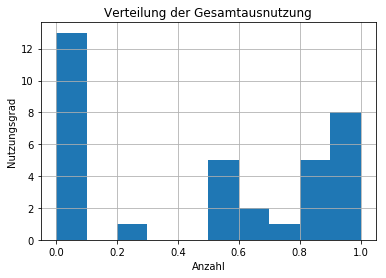

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
ax = coverage.covered.hist();
ax.set_title("Verteilung der Gesamtausnutzung")
ax.set_xlabel("Anzahl")
ax.set_ylabel("Nutzungsgrad");

### Vorbereitung Verbindung zu technischen Schulden
* Es wird ein eindeutiger Schlüssel ("fqn") für die Softwareinheiten erstellt, um nachfolgend Nutzungsdaten zu den technischen Schulden zuordnen zu können
* Zudem werden nicht mehr benötigte Daten weggelassen

In [4]:
coverage['fqn'] = coverage.PACKAGE + "." + coverage.CLASS
coverage_per_class = coverage.set_index('fqn')[['lines', 'covered']]
coverage_per_class.head()

,lines,covered
fqn,,
org.springframework.samples.petclinic.PetclinicInitializer,24,1.0
org.springframework.samples.petclinic.model.NamedEntity,5,0.8
org.springframework.samples.petclinic.model.Specialty,1,1.0
org.springframework.samples.petclinic.model.PetType,1,1.0
org.springframework.samples.petclinic.model.Vets,4,0.0


## Technische Schulden in der Software
Zur Bewertung der Softwarequalität werden die technischen Schulden pro Softwareeinheit herangezogen.

In [5]:
# in C:\dev\repos\software-analytics\demos\dataset
# python -m "http.server" 28080
#URL = "http://localhost:28080/sonarqube_search.json"

### Laden der aktuellen Daten vom Qualitätssicherungsserver
Die aktuellen Messergebnisse der technischen Schulden der Anwendung werden geladen.

In [6]:
#import json
#
#issues_json = ""
#
#with open ("../dataset/sonarqube_search.json") as f:
#    issues_json = json.loads(f.read())
#    
#json.dumps(issues_json)[:200]

In [7]:
import requests
KEY = "org.springframework.samples:spring-petclinic:boundedcontexts"
URL = "https://sonarcloud.io/api/issues/search?languages=java&componentKeys=" + KEY
issues_json = requests.get(URL).json()
print(str(issues_json)[:500])

{'total': 55, 'p': 1, 'ps': 100, 'paging': {'pageIndex': 1, 'pageSize': 100, 'total': 55}, 'issues': [{'key': 'AWLJtvMj-pl6AHs2EogL', 'rule': 'squid:S3008', 'severity': 'MINOR', 'component': 'org.springframework.samples:spring-petclinic:boundedcontexts:src/main/java/org/springframework/samples/petclinic/util/BrokenSingleton.java', 'project': 'org.springframework.samples:spring-petclinic:boundedcontexts', 'line': 5, 'hash': '48c1dff4bc3cd8f9b9b8c76f49484c2a', 'textRange': {'startLine': 5, 'endLin


### Aufstellung der notwendigen Daten für tiefergehende Analysen
* Es wird nur der Name der vermessenen Softwareeinheit benötigt sowie die berechnete Dauer der technischen Schulden
* Die Dauer der technischen Schulden wird entsprechend als Zeitdauer umgewandelt

In [8]:
from pandas.io.json import json_normalize
issues = json_normalize(issues_json['issues'])[['component', 'debt']]
issues['debt'] = issues.debt.apply(pd.Timedelta)
issues.head()

,component,debt
0,org.springframework.samples:spring-petclinic:b...,00:02:00
1,org.springframework.samples:spring-petclinic:b...,00:20:00
2,org.springframework.samples:spring-petclinic:b...,00:10:00
3,org.springframework.samples:spring-petclinic:b...,00:05:00
4,org.springframework.samples:spring-petclinic:b...,00:15:00


### Vorbereitung der Zuordnung zu Auslastungsdaten
* Es wird ein eindeutiger Schlüssel für die Softwareinheiten erstellt, um technischen Schulden zu Nutzungsdaten zuordnen zu können
* Mehrfacheinträge zu technischen Schulden werden pro Softwareeinheit aufsummiert

In [9]:
issues['fqn'] = issues.component.str.extract("/java/(.*).java", expand=True)
issues['fqn'] = issues.fqn.str.replace("/", ".")
debt_per_class = issues.groupby('fqn')[['debt']].sum()
debt_per_class.head()

,debt
fqn,
org.springframework.samples.petclinic.PetclinicInitializer,00:04:00
org.springframework.samples.petclinic.model.Pet,00:02:00
org.springframework.samples.petclinic.model.Vets,00:10:00
org.springframework.samples.petclinic.repository.OwnerRepository,00:15:00
org.springframework.samples.petclinic.repository.PetRepository,00:15:00


## Erstellung der Management-Sicht

### Zusammenführung der Daten
* Nutzungsdaten und technische Schulden werden anhand der Schlüssel der Softwareeinheiten zusammengefasst.

In [10]:
analysis = coverage_per_class.join(debt_per_class)
analysis = analysis.fillna(0)
analysis.head()

,lines,covered,debt
fqn,,,
org.springframework.samples.petclinic.PetclinicInitializer,24,1.0,00:04:00
org.springframework.samples.petclinic.model.NamedEntity,5,0.8,00:00:00
org.springframework.samples.petclinic.model.Specialty,1,1.0,00:00:00
org.springframework.samples.petclinic.model.PetType,1,1.0,00:00:00
org.springframework.samples.petclinic.model.Vets,4,0.0,00:10:00


### Durchschnittliche Nutzung nach fachlicher Sicht

In [11]:
analysis['domain'] = "Other"

domains = ["Owner", "Pet", "Visit", "Vet", "Specialty", "Clinic"]
for domain in domains:
    analysis.loc[analysis.index.str.contains(domain), 'domain'] = domain

analysis.groupby('domain')[['covered']].mean()

,covered
domain,
Clinic,0.888889
Other,0.480208
Owner,0.549495
Pet,0.594156
Specialty,1.000000
Vet,0.176667
Visit,0.385417


### Nutzungsgrad und technische Schulden nach fachlichen Komponenten

In [12]:
management_compatible_data = analysis.\
    groupby('domain').\
    agg({"covered": "mean", "debt" : "sum", "lines" : "sum"})
management_compatible_data.debt = management_compatible_data.debt.dt.seconds / 60
management_compatible_data.columns = \
    ['Nutzungsgrad (%)', 'Technische Schulden (min)', 'Größe']
management_compatible_data.head()

,Nutzungsgrad (%),Technische Schulden (min),Größe
domain,,,
Clinic,0.888889,40.0,18
Other,0.480208,117.0,57
Owner,0.549495,65.0,130
Pet,0.594156,30.0,153
Specialty,1.000000,0.0,1


## Executive Summary

### Bewertungsmatrix nach fachlichen Gesichtspunkten

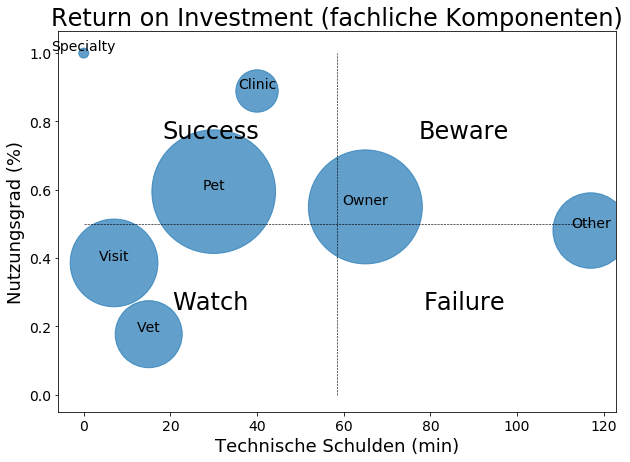

In [13]:
%matplotlib inline
from ausi import portfolio
portfolio.plot_diagram(management_compatible_data, "Technische Schulden (min)", "Nutzungsgrad (%)", "Größe", "fachliche Komponenten");

## Zusammenfassung 

**Erkenntnisse**
* Die Investitionen in die Kernfunktionalität rund um die Betreuung von Haustieren ("Pet") haben sich bisher ausgezeichnet.
* Risiko besteht bei den "sonstigen Modulen" ("Other"):
 * Die Nutzung der Komponente ist weniger als 50%
 * Die technischen Schulden sind hier am höchsten mit 120 Minuten

**Maßnahme:** Für die Komponente "Other" müssen dringends qualitätsverbessernde Maßnahmen ergriffen werden

## Anhang

Nutzung nach technischen Komponenten

### Nutzungsgrad und technische Schulden nach technischen Komponenten

In [14]:
analysis['tech'] = analysis.index.str.split(".").str[-2]
analysis.groupby('tech')[['covered']].mean()

,covered
tech,
jdbc,0.000000
jpa,0.691558
model,0.739048
petclinic,1.000000
service,0.888889
util,0.135417
web,0.639809


### Nutzungsgrad nach technischen Funktionen

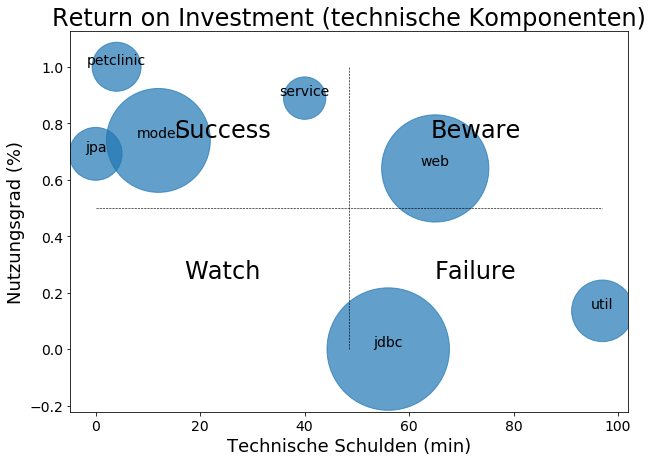

In [15]:
management_compatible_data = analysis.groupby('tech').agg({"covered": "mean", "debt" : "sum", "lines" : "sum"})
management_compatible_data.debt = management_compatible_data.debt.dt.seconds / 60
management_compatible_data.columns = ['Nutzungsgrad (%)', 'Technische Schulden (min)', 'Größe']
portfolio.plot_diagram(management_compatible_data, "Technische Schulden (min)", "Nutzungsgrad (%)", "Größe", "technische Komponenten");

## Ende